# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Cкачайте его кстати, 

In [1]:
!mkdir cifar10
!curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz -C cifar10

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162M  100  162M    0     0  1909k      0  0:01:27  0:01:27 --:--:-- 1905k
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

In [3]:
print X_train.shape, y_train.shape, X_test.shape, y_test.shape

(50000, 3, 32, 32) (50000,) (10000, 3, 32, 32) (10000,)


In [4]:
y_train = y_train.astype(np.int32)
X_train = X_train.astype(np.float32)
y_test = y_test.astype(np.int32)
X_test = X_test.astype(np.float32)

### Whitening

In [94]:
def flatten_matrix(matrix):
    vector = matrix.flatten(1)
    #vector = vector.reshape(1, len(vector))
    return vector

def whiten(X):
    X -= np.mean(X, axis = 0) # zero-center
    cov = np.dot(X, X.T) # compute the covariance matrix
    U,S,V = np.linalg.svd(cov) # compute the SVD factorization of the data covariance matrix
    X_rot = np.dot(X, U) # decorrelate the data
    X_white = X_rot / np.sqrt(S + 1e-5) # divide by the eigenvalues (which are square roots of the singular values)
    return X_white

In [95]:
X_flattened = np.array([flatten_matrix(X_train[i]) for i in xrange(X_train.shape[0])])
X_train = whiten(X_flattened)

/home/ec2-user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  from ipykernel import kernelapp as app


MemoryError: 

In [5]:
from sklearn import cross_validation

/home/ec2-user/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
X_train, X_val, y_train, y_val = cross_validation.train_test_split(X_train, y_train, test_size = 0.1)

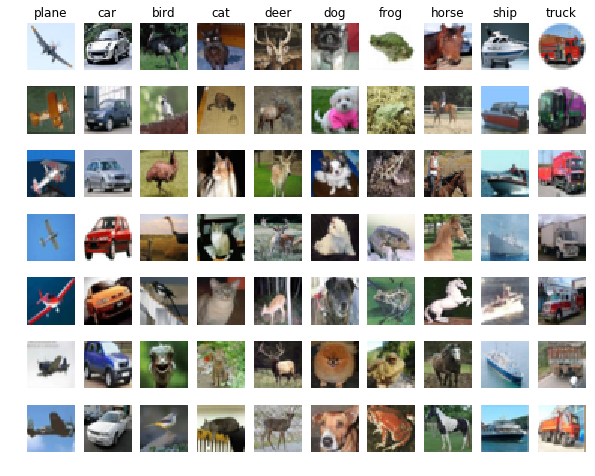

In [7]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Чем отличаются современные сверточные сети от сетей 5 летней давности?

Раньше сети были неглубокие(порядка 11 слоёв), сейчас сети порядка 150 слоёв, придуманы разные архитектуры сетей:
GoogleNet - так как сеть глубокая, слои, которые глубже не обучаются, если сделать один loss слой(градиенты затухают), поэтому в ней много слоёв с softmax. По сути является сетью, состоящей из нескольких менее глубоких сетей. Также в GoogleNet используются всевозможные свертки

ResNet - к VCG добавляются дополнительные слои и shortcuts + batch normalization, получаем несколько сетей разной глубины, которые тренируются одновременно(у этих сетей общие слои и параметры)(важно - одинаковые размерности)
AlexNet, VGG, GoogleNet, ResNet

**Вопрос 2**: Какие неприятности могут возникнуть во время обучения современных нейросетей?

Глубокая сеть может не обучаться из-за затухания градиентов, затухание активаций(все нули на каком-то слое), долгое время работы во время применения сети, их надо адаптировать для реальных задач.

**Вопрос 3**: У вас есть очень маленький датасет из 100 картинок, классификация, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить? что делать если первый вариант  решения не заработает?

<Ответ>

**Вопрос 4**: Как сделать стайл трансфер для музыки? oO

Построить спектограмму для записи, спектрограмму для записи определённого стиля. Обучаем сеть так, чтобы loss учитывал и ту и другую картинку.

In [8]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor4("X")
target_y = T.vector("target Y integer",dtype='int32')

Using cuDNN version 5110 on context None
Mapped name None to device cuda0: GRID K520 (0000:00:03.0)


### Соберите нейронку: 
- Many times x (Conv+Pool)
- Many small convolutions like 3x3
- Batch Norm 
- Residual Connection
- Data Augmentation 
- Learning rate Schedule 
- ...

### Для вдохновения 
- http://torch.ch/blog/2015/07/30/cifar.html
- https://github.com/szagoruyko/wide-residual-networks 

### Самое интересное
- Для сдачи задания нужно набрать на точность тесте > **92.5**% (это займет много времени, торопитесь :) )
- Для получения бонусных баллов > **95.0**%
- Будет очень хорошо если вы придумаете свою архитектуру или сможете обучить что-то из вышеперечисленного :)
- А для обучения всего этого добра вам будет куда удобнее использовать GPU на Amazon 
    - Инструкция https://github.com/persiyanov/ml-mipt/tree/master/amazon-howto 
    - Вам помогут tmux, CuDNN, ssh tunnel, nvidia-smi, ... 
    - Have fun :)

In [15]:
net = lasagne.layers.InputLayer(shape=(None, 3, 32, 32), input_var=input_X)

net = lasagne.layers.Conv2DLayer(net, num_filters=30, filter_size=(3, 3)) # сверточный слой
net = lasagne.layers.BatchNormLayer(net)
net = lasagne.layers.NonlinearityLayer(net)
#net = lasagne.layers.DropoutLayer(net, 0.3)  
#net = lasagne.layers.MaxPool2DLayer(net, pool_size=(2, 2))

net = lasagne.layers.Conv2DLayer(net, num_filters=30, filter_size=(3, 3)) # сверточный слой
net = lasagne.layers.BatchNormLayer(net)
net = lasagne.layers.NonlinearityLayer(net) 
#net = lasagne.layers.MaxPool2DLayer(net, pool_size=(2, 2))

net = lasagne.layers.Conv2DLayer(net, num_filters=30, filter_size=(3, 3)) # сверточный слой
net = lasagne.layers.BatchNormLayer(net)
net = lasagne.layers.NonlinearityLayer(net)
#net = lasagne.layers.DropoutLayer(net, 0.4)  
#net = lasagne.layers.MaxPool2DLayer(net, pool_size=(2, 2))

net = lasagne.layers.Conv2DLayer(net, num_filters=30, filter_size=(3, 3)) # сверточный слой
net = lasagne.layers.BatchNormLayer(net)
net = lasagne.layers.NonlinearityLayer(net)
#net = lasagne.layers.MaxPool2DLayer(net, pool_size=(2, 2))

net = lasagne.layers.Conv2DLayer(net, num_filters=30, filter_size=(3, 3)) # сверточный слой
net = lasagne.layers.BatchNormLayer(net)
net = lasagne.layers.NonlinearityLayer(net)
#net = lasagne.layers.DropoutLayer(net, 0.4)
net = lasagne.layers.MaxPool2DLayer(net, pool_size=(2, 2))

#net = lasagne.layers.DropoutLayer(net, 0.5)
net = lasagne.layers.DenseLayer(net, num_units=300)
#net = lasagne.layers.BatchNormLayer(net)
#net = lasagne.layers.NonlinearityLayer(net)
net = lasagne.layers.DropoutLayer(net, 0.5)         # регуляризатор

net = lasagne.layers.DenseLayer(net,num_units = 10, nonlinearity=softmax)

In [9]:
def block(net, num_filters=192, filter_size=(1, 1), pad=0):
    net = lasagne.layers.Conv2DLayer(net, num_filters=num_filters, filter_size=filter_size, pad=pad) # сверточный слой
    net = lasagne.layers.BatchNormLayer(net, epsilon=1e-5)
    net = lasagne.layers.NonlinearityLayer(net)
    return net

net = lasagne.layers.InputLayer(shape=(None, 3, 32, 32), input_var=input_X)
print lasagne.layers.get_output_shape(net)

net = block(net, filter_size=(5, 5), pad=2)
net = block(net, num_filters=160)
net = block(net, num_filters=96)
net = lasagne.layers.MaxPool2DLayer(net, pool_size=(3, 3), stride=(2, 2))
print lasagne.layers.get_output_shape(net)
#print shape
#net = lasagne.layers.DenseLayer(net,num_units = shape[0]*shape[1]*shape[2]*shape[3], nonlinearity=softmax)

#net = lasagne.layers.InputLayer(shape=shape, input_var=input_X)
net = block(net, filter_size=(5, 5), pad=2)
net = block(net)
net = block(net)
net = lasagne.layers.Pool2DLayer(net, mode='average_inc_pad', pool_size=(3, 3), stride=(2, 2))
print lasagne.layers.get_output_shape(net)
#print shape
#net = lasagne.layers.DenseLayer(net,num_units = shape[0]*shape[1]*shape[2]*shape[3], nonlinearity=softmax)

#net = lasagne.layers.InputLayer(shape=shape, input_var=input_X)
net = block(net, filter_size=(3, 3), pad=1)
net = block(net)
net = block(net)
net = lasagne.layers.Pool2DLayer(net, mode='average_inc_pad', pool_size=(7, 7))
print lasagne.layers.get_output_shape(net)
#print shape
#net = lasagne.layers.DenseLayer(net,num_units = shape[0]*shape[1]*shape[2]*shape[3], nonlinearity=softmax)

net = lasagne.layers.DenseLayer(net, num_units=192)
net = lasagne.layers.DropoutLayer(net, 0.5)         # регуляризатор

net = lasagne.layers.DenseLayer(net,num_units = 10, nonlinearity=softmax)

(None, 3, 32, 32)
(None, 96, 15, 15)
(None, 192, 7, 7)
(None, 192, 1, 1)


In [10]:
y_predicted = lasagne.layers.get_output(net)
all_weights = lasagne.layers.get_all_params(net, regularizable=True)
print all_weights

[W, gamma, W, gamma, W, gamma, W, gamma, W, gamma, W, gamma, W, gamma, W, gamma, W, gamma, W, W]


In [11]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()

In [12]:
updates = lasagne.updates.adam(loss, all_weights, learning_rate=0.01)

In [13]:
train_fun = theano.function([input_X,target_y],[loss, accuracy], updates=updates)
accuracy_fun = theano.function([input_X,target_y],accuracy)

### Вот и всё, пошли её учить

In [14]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Процесс обучения

In [15]:
import time

num_epochs = 10 #количество проходов по данным

batch_size = 50 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

Epoch 1 of 10 took 172.762s
  training loss (in-iteration):		1.850928
  train accuracy:		30.63 %
  validation accuracy:		37.50 %
Epoch 2 of 10 took 172.797s
  training loss (in-iteration):		1.571504
  train accuracy:		42.23 %
  validation accuracy:		46.82 %
Epoch 3 of 10 took 172.841s
  training loss (in-iteration):		1.384187
  train accuracy:		50.61 %
  validation accuracy:		54.90 %
Epoch 4 of 10 took 172.877s
  training loss (in-iteration):		1.219817
  train accuracy:		57.02 %
  validation accuracy:		59.32 %
Epoch 5 of 10 took 172.902s
  training loss (in-iteration):		1.095174
  train accuracy:		61.61 %
  validation accuracy:		63.56 %
Epoch 6 of 10 took 172.969s
  training loss (in-iteration):		0.995381
  train accuracy:		65.74 %
  validation accuracy:		67.00 %
Epoch 7 of 10 took 172.998s
  training loss (in-iteration):		0.912864
  train accuracy:		69.17 %
  validation accuracy:		68.14 %
Epoch 8 of 10 took 172.944s
  training loss (in-iteration):		0.834533
  train accuracy:		71.92 %


In [16]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 92.5:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

Final results:
  test accuracy:		73.66 %
Нужно больше магии!


## Заполните форму

https://goo.gl/forms/EeadABISlVmdJqgr2 